In [14]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import zipfile
import shutil
import warnings
from typing import List
from typing import Tuple
from sklearn.metrics import roc_curve, auc

warnings.filterwarnings('ignore')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, AveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.models import load_model

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth when using GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

2024-08-09 05:34:36.800595: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-09 05:34:37.570799: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-09 05:34:37.571032: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
seed = 42
tf.random.set_seed(seed)

In [4]:

# folder_path = 'EFlow Images'


# #Extracting the zip files
# parent_data_path = 'EFlow Images/data' #Creating new directory for extracting the images

# for zipName in os.listdir(folder_path):
#     zip_path = os.path.join(folder_path, zipName)
    
#     if zipName[-4:] != '.zip':
#         continue
    
#     print(f'Extracting: {zipName}...')

#     extract_path = os.path.join(parent_data_path, zipName[:-4])
#     with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#         for member in zip_ref.namelist():
#             if member.endswith('.png'):
#                 #print(member)
#                 zip_ref.extract(member, extract_path)
    
#     print(f'----Extraction of {zipName} Completed----\n')
#     print(100*'~')


Found 19675 files belonging to 2 classes.


2024-08-09 05:34:39.489570: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-09 05:34:39.489833: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-09 05:34:39.489987: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

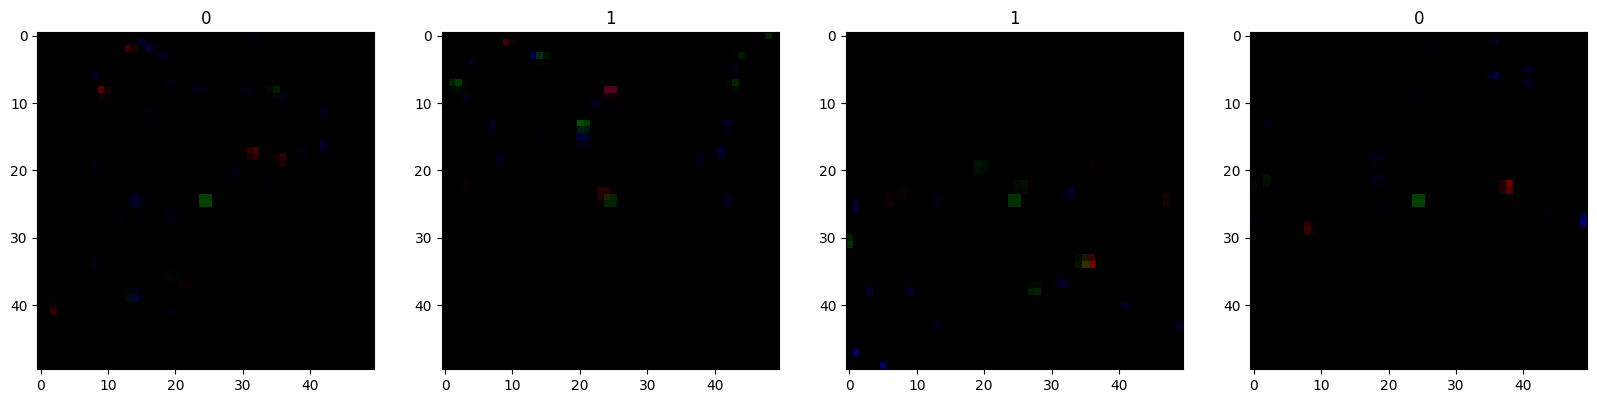

In [5]:
data_dir = 'EFlow Images/data'

data = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                   seed=seed,
                                                   batch_size = 200,
                                                   image_size = (50,50))

data = data.map(lambda x, y: (x/255, y))

data_iterator = data.as_numpy_iterator()

batch = data_iterator.next()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [6]:
train_size = int(len(data)*.7) #70% of total batches as training data
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [7]:
model3 = Sequential()

model3.add(Conv2D(128, (5,5), 1, padding = 'same', activation='relu', input_shape=(50,50,3)))
model3.add(AveragePooling2D(pool_size = (2,2),strides=1)) #2x2 filter

model3.add(Conv2D(64, (3,3), 1, activation='relu'))
model3.add(AveragePooling2D(pool_size = (2,2)))

model3.add(Conv2D(32, (3,3), 1, activation='relu'))
model3.add(AveragePooling2D(pool_size = (2,2), strides=1,
                        padding='same'))

model3.add(Conv2D(16, (2,2), 1, activation='relu'))
model3.add(AveragePooling2D(pool_size = (2,2)))

model3.add(Conv2D(8, (2,2), 1, activation='relu'))
model3.add(AveragePooling2D(pool_size = (2,2)))

model3.add(Flatten())

model3.add(Dense(256, activation='relu'))
model3.add(Dense(512, activation='relu'))
model3.add(Dense(1, activation='sigmoid'))

In [8]:
model3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 50, 50, 128)    │         9,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 49, 49, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 23, 23, 64)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 21, 21, 32)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 20, 20, 16)     │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_3             │ (None, 10, 10, 16)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 9, 9, 8)        │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_4             │ (None, 4, 4, 8)        │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 269,689 (1.03 MB)

 Trainable params: 269,689 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
model3.compile('adam', 
              loss=tf.losses.BinaryCrossentropy(), 
              metrics=['accuracy',
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                       tf.keras.metrics.AUC(),
                       tf.keras.metrics.TruePositives(),
                       tf.keras.metrics.FalsePositives(),
                       tf.keras.metrics.TrueNegatives(),
                       tf.keras.metrics.FalseNegatives()])

In [10]:
logdir = 'EFlow Images/logs3_1'

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

checkpoint_callback = ModelCheckpoint(
    filepath='EFlow Images/alex_netClassifier.keras',  # Path to save the model file
    save_weights_only=False,          # Whether to save the full model or just weights
    monitor='val_accuracy',               # Quantity to monitor (e.g., 'val_loss', 'accuracy')
    mode='auto',                      # Mode to determine whether to maximize or minimize the monitored quantity
    save_best_only=True,              # Save the best model only
    verbose=10                         # Verbosity mode
)

hist3 = model3.fit(train,
                 epochs = 10,
                 validation_data = val, 
                 callbacks = [tensorboard_callback, checkpoint_callback])

Epoch 1/10


I0000 00:00:1723181686.385227    2680 service.cc:145] XLA service 0x7f51c00055c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1723181686.385403    2680 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-08-09 05:34:46.519160: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-09 05:34:46.999469: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8900
I0000 00:00:1723181698.290234    2680 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.5100 - auc: 0.5148 - false_negatives: 1235.3623 - false_positives: 2148.1016 - loss: 0.6916 - precision: 0.5083 - recall: 0.6872 - true_negatives: 1373.2029 - true_positives: 2243.3333
Epoch 1: val_accuracy improved from -inf to 0.55342, saving model to EFlow Images/alex_netClassifier.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 56s 584ms/step - accuracy: 0.5104 - auc: 0.5153 - false_negatives: 1262.9286 - false_positives: 2164.3713 - loss: 0.6915 - precision: 0.5086 - recall: 0.6850 - true_negatives: 1406.0286 - true_positives: 2263.8142 - val_accuracy: 0.5534 - val_auc: 0.6006 - val_false_negatives: 1639.0000 - val_false_positives: 58.0000 - val_loss: 0.6838 - val_precision: 0.8380 - val_recall: 0.1547 - val_true_negatives: 1803.0000 - val_true_positives: 300.0000
Epoch 2/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.5839 - auc: 0.6027 - false_negatives: 2055.2463 - false_positives: 806.3333 - loss: 0.6697 - precision: 0.6524 - re

In [11]:
def plotROC(*,test_data = None, model = None):
    '''
    test_data: tensorflow.python.data.ops.take_op._TakeDataset
    '''
    y_pred = model.predict(test_data)

    test_data_list = list(test_data)
    labels = []
    for batch in test_data_list:
        images, label = batch
        labels.append(label.numpy())
    y_true = np.concatenate(labels, axis=0)
    
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    plt.figure()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, label = f'AUC:{auc(fpr, tpr)}')
    plt.legend()
    plt.show()

    

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


2024-08-09 05:38:22.353575: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


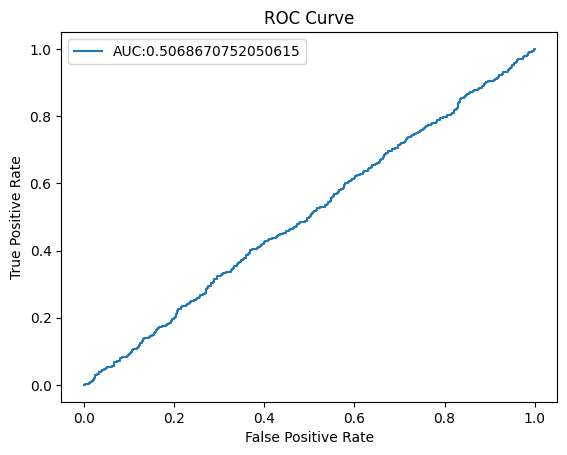

In [15]:
plotROC(test_data = test, model = model3)